In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [13]:
import deepmatcher as dm
from utilities_functions.intermediate_layer_extraction import return_layer_input
from utilities_functions.ri_calculator import find_smallest_variation_to_change_v1
import torch
import pandas as pd

In [28]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/dblp_acm_hybrid.pth')

In [5]:
testneg_classifier_inputs,testneg_ids = return_layer_input('../../Structured/DBLP-ACM/','negatives_frac',
                                                           batch_size=128,model=model,layer=model.classifier,
                                                          device=-1)

In [6]:
testpos_classifier_inputs,testpos_ids = return_layer_input('../../Structured/DBLP-ACM/','positives_frac',
                                                           batch_size=128,model=model,layer=model.classifier,
                                                          device=-1)

In [7]:
model = model.cuda()

In [8]:
from tqdm import tqdm

In [9]:
attributes = ['title','authors','venue','year']
## Basta scegliere un campione a caso
classifier_length = len(testneg_classifier_inputs[0][0])
attribute_length = int(classifier_length/len(attributes))

In [10]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri = []
for batch in testneg_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            variation = find_smallest_variation_to_change_v1(model.classifier,
                                                             classifier_length= classifier_length,
                                                             attribute_length= attribute_length,
                                                          input_matrix=batch,
                                                             vector_index=sample_index,attributes=[j],
                                                          class_to_reach=1)
            current_sample_ris.append(variation)
        negatives_ri.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [00:25<00:00,  4.67it/s]


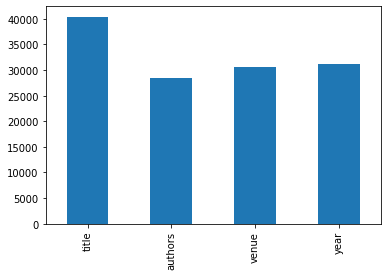

In [15]:
ri_norms_negative_samples = []
for ri_list in negatives_ri:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
negatives_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)
ri_sums = negatives_variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

In [16]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri = []
for batch in testpos_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            variation = find_smallest_variation_to_change_v1(model.classifier,
                                                             classifier_length= classifier_length,
                                                             attribute_length= attribute_length,
                                                          input_matrix=batch,
                                                             vector_index=sample_index,attributes=[j],
                                                          class_to_reach=0)
            current_sample_ris.append(variation)
        positives_ri.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [00:18<00:00,  6.98it/s]


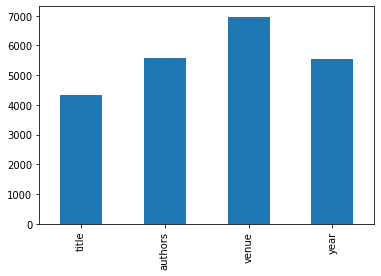

In [17]:
ri_norms_positives = []
for ri_list in positives_ri:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
positives_variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)
positives_variation_df.sum(numeric_only=True).plot.bar()

In [18]:
negatives_variation_df.to_csv('experiment_results/testneg_v1_ri.csv',index=False)

In [19]:
positives_variation_df.to_csv('experiment_results/testpos_v1_ri.csv',index=False)

## Nearest neighbors discovery

In [20]:
from utilities_functions.distance_measures import nearest_neighbor_onAttribute

In [22]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/DBLP-ACM/','positives',
                                                           batch_size=128,model=model,layer=model.classifier,
                                                          device=-1)


Reading and processing data from "../../Structured/DBLP-ACM/positives.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [23]:
model=  model.cuda()

In [24]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
negatives_closer_vectors = []
i = 0
for batch in testneg_classifier_inputs:
    for sample in tqdm(batch):
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbor_onAttribute
                                                 (sample+negatives_ri[i][attributes.index(att)]
                                                                ,pos_classifier_inputs,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        negatives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

100%|██████████| 128/128 [03:05<00:00,  1.37s/it]


In [27]:
negatives_closer_vectors_df = pd.DataFrame(data = negatives_closer_vectors, columns = attributes)
negatives_closer_vectors_df = negatives_closer_vectors_df.applymap(lambda c:pos_ids[c])
negatives_closer_vectors_df['SampleID'] = testneg_ids
negatives_closer_vectors_df.to_csv('experiment_results/negatives_nn.csv',index=False)

In [29]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/DBLP-ACM/','negatives',
                                                           batch_size=128,model=model,layer=model.classifier,
                                                          device=-1)


Reading and processing data from "../../Structured/DBLP-ACM/negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [##########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01

Computing principal components
0% [##########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


In [30]:
model = model.cuda()

In [43]:
import torch.nn.functional as F
negative_tensors = list(map(lambda b: b.data,neg_classifier_inputs))
all_neg_tensors = torch.cat(negative_tensors)
negatives_var = torch.autograd.Variable(all_neg_tensors,requires_grad=True)

In [66]:
import numpy as np
def nearest_neighbor_cosine(v,data,attribute_idx,attribute_length):
    start_index = attribute_idx*attribute_length
    end_index = start_index+attribute_length
    distances = F.cosine_similarity(v[start_index:end_index],data[:,start_index:end_index],dim=-1).data.cpu().numpy()
    best = max(distances)
    return np.where(distances == best)[0][0]

In [70]:
# per ogni attributo trovo il più vicino
positives_closer_vectors = []
i = 0
for batch in testpos_classifier_inputs:
    for sample in tqdm(batch):
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbor_cosine
                                                 (sample+positives_ri[i][attributes.index(att)]
                                                                ,negatives_var,attributes.index(att),
                                                                attribute_length),attributes))
        positives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 


100%|██████████| 128/128 [00:01<00:00, 122.32it/s]

In [75]:
positives_closer_vectors_df = pd.DataFrame(data = positives_closer_vectors, columns = attributes)
positives_closer_vectors_df = positives_closer_vectors_df.applymap(lambda c:neg_ids[c])
positives_closer_vectors_df['SampleID'] = testpos_ids
positives_closer_vectors_df.to_csv('experiment_results/positives_nn.csv',index=False)